# PyTorch, Data Loaders, And Logistic Regression
## Chris Tralie



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from scipy import signal

# Torch Data Loader for 2D Blobs

In [2]:
class Evens:
    def __init__(self, N):
        self.N = N
    
    def __len__(self):
        return self.N
    
    def __getitem__(self, i):
        return 2*(i+1)

evens = Evens(100)
for i in range(len(evens)):
    print(evens[i], end=" ")

2 4 6 8 10 12 14 16 18 20 22 24 26 28 30 32 34 36 38 40 42 44 46 48 50 52 54 56 58 60 62 64 66 68 70 72 74 76 78 80 82 84 86 88 90 92 94 96 98 100 102 104 106 108 110 112 114 116 118 120 122 124 126 128 130 132 134 136 138 140 142 144 146 148 150 152 154 156 158 160 162 164 166 168 170 172 174 176 178 180 182 184 186 188 190 192 194 196 198 200 

## Setup blobs dataset and solve logistic regression

In [3]:
class Blobs(Dataset):
    def __init__(self, n_samples, dim, offset):
        """
        Parameters
        ----------
        n_samples: int
            The number of data points in the dataset
        dim: int
            Dimension of each point
        offset: float
            The amount to add to each dimension of each point in class 1
        """
        self.n_samples = n_samples
        self.dim = dim
        self.offset = np.ones(dim)*offset
    
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, idx):
        """
        Return a tuple (x, y)
        """
        y = np.random.randint(2)
        x = np.random.randn(self.dim)
        if y == 1:
            x += self.offset
        x = torch.from_numpy(np.array(x, dtype=np.float32))
        y = torch.from_numpy(np.array(y, dtype=np.float32))
        return x, y

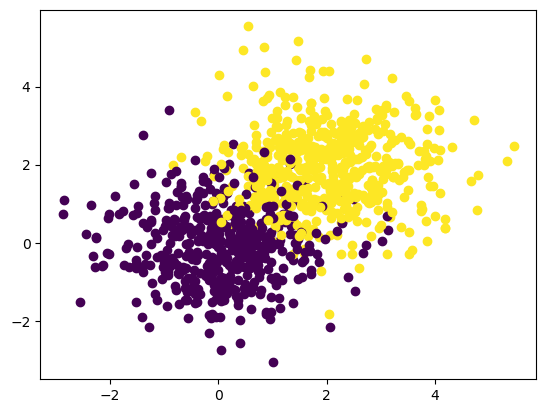

In [4]:
n_samples = 1000
data = Blobs(n_samples, dim=2, offset=2)
for i in range(len(data)):
    x, y = data[i]
    plt.scatter(x[0], x[1], c=y, vmin=0, vmax=1)


## Data Loaders / Mini-Batch Gradient Descent

X.shape torch.Size([16, 2])
Y.shape torch.Size([16])


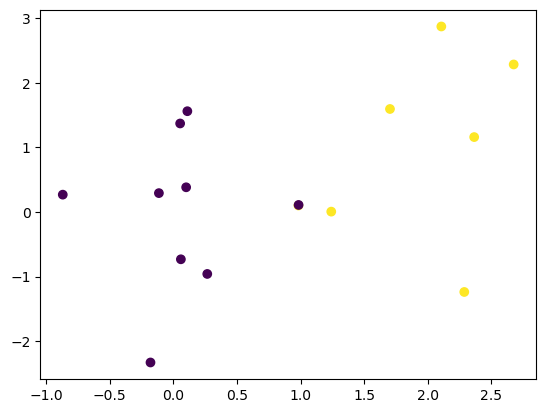

In [5]:
n_samples = 1000
dim = 2
offset = 2
## Step 1: Gather data
data = Blobs(n_samples, dim, 2)

loader = DataLoader(data, batch_size=16, shuffle=True)
X, Y = next(iter(loader))
print("X.shape", X.shape)
print("Y.shape", Y.shape)
plt.scatter(X[:, 0], X[:, 1], c=Y)

## PyTorch Training Loop

In [6]:
# Try to use the GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
print("Device: ", device)

## Step 2: Create model (setup a function space), logistic perceptron
perceptron = nn.Linear(dim, 1)
perceptron = perceptron.to(device)

## Step 3: Setup the loss function
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(perceptron.parameters(), lr=0.001)

n_epochs = 50 # Each "epoch" is a loop through the entire dataset
# and we use this to update the parameters
losses = []
accuracy = []
for epoch in range(n_epochs):
    print(".", end="")
    loader = DataLoader(data, batch_size=16, shuffle=True)
    for X, Y in loader: # Go through each mini batch
        # Move inputs/outputs to GPU
        X = X.to(device)
        Y = Y.to(device)
        # Reset the optimizer's gradients
        optimizer.zero_grad()
        # Run the perceptron model on all inputs
        Y_est = perceptron(X)
        # Compute the loss function comparing Y_est to Y
        loss = loss_fn(Y_est[:, 0], Y)
        # Compute the gradients of the loss function with respect
        # to all of the parameters of the model
        loss.backward()
        # Update the parameters based on the gradient and
        # the optimization scheme
        optimizer.step()
        
    # Look at results on test set
    test_loader = DataLoader(data, batch_size=len(data))
    inputs, labels = next(iter(test_loader))
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = perceptron(inputs)
    total_loss = loss_fn(outputs[:, 0], labels)
    num_correct = torch.sum(0.5*(torch.sign(outputs[:, 0])+1) == labels)
    losses.append(total_loss.item())
    accuracy.append(num_correct.cpu()/len(data))

Device:  cuda
..................................................

## Plot Optimization Progress

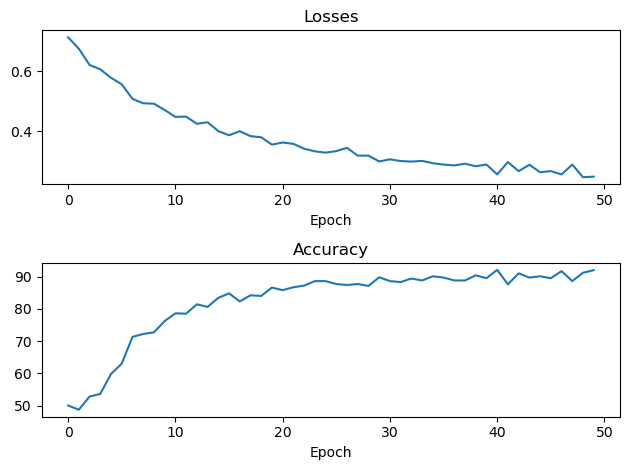

In [7]:
plt.figure()
plt.subplot(211)
plt.plot(losses)
plt.title("Losses")
plt.xlabel("Epoch")
plt.subplot(212)
plt.plot(np.array(accuracy)*100)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.tight_layout()

## Extract Parameters And Plot Some Results

1.0123471 1.0198363 -1.591359


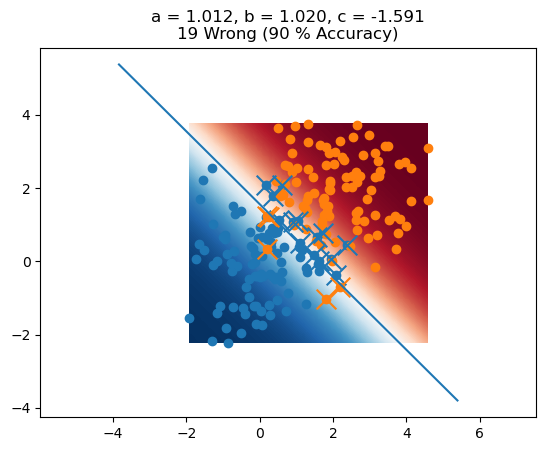

In [8]:
[ab, c] = list(perceptron.parameters())
ab = ab.detach().cpu().numpy().flatten()
a, b = ab
c = c.detach().cpu().numpy().flatten()[0]
print(a, b, c)


X0 = []
X1 = []
for i in range(200):
    x, y = data[i]
    x = x.detach().cpu().numpy()
    if y == 0:
        X0.append(x)
    else:
        X1.append(x)
X0 = np.array(X0)
X1 = np.array(X1)

logistic = lambda u: 1/(1 + np.exp(-u))


def plot_logistic_regression_predictions(X1, X2, a, b, c):
    plt.scatter(X1[:, 0], X1[:, 1])
    plt.scatter(X2[:, 0], X2[:, 1])
    X = np.concatenate((X1, X2), axis=0)
    xmin = np.min(X, axis=0)
    xmax = np.max(X, axis=0)
    iv = max(xmax[1]-xmin[1], xmax[0]-xmin[0])
    
    resol = 200
    mx = 2
    xx = np.linspace(xmin[0], xmax[0], resol)
    yy = np.linspace(xmin[1], xmax[1], resol)
    xx, yy = np.meshgrid(xx, yy)
    plt.imshow(logistic(a*xx+b*yy+c), extent=(xmin[0], xmax[0], xmax[1], xmin[1]), cmap='RdBu_r', vmin=0, vmax=1)
    
    
    p0 = -c*np.array([a, b])/(a**2 + b**2)
    v = np.array([-b, a])
    mag = np.sqrt(np.sum(v**2))
    if mag > 0:
        v = v/mag
        p = p0 - iv*v
        q = p0 + iv*v
        plt.plot([p[0], q[0]], [p[1], q[1]])
        rg = xmax[0] - xmin[0]
        plt.xlim([xmin[0]-0.2*rg, xmax[0]+0.2*rg])
        rg = xmax[1] - xmin[1]
        plt.ylim([xmin[1]-0.2*rg, xmax[1]+0.2*rg])

        wrong = 0
        for x in X1:
            y = logistic(a*x[0] + b*x[1] + c)
            proj = p0 + np.sum(v*(x-p0))*v
            #plt.plot([x[0], proj[0]], [x[1], proj[1]], c='C0')
            if y > 0.5:
                plt.scatter([x[0]], [x[1]], 200, c='C0', marker='x')
                wrong += 1
        for x in X2:
            y = logistic(a*x[0] + b*x[1] + c)
            proj = p0 + np.sum(v*(x-p0))*v
            #plt.plot([x[0], proj[0]], [x[1], proj[1]], c='C1')
            if y < 0.5:
                plt.scatter([x[0]], [x[1]], 200, c='C1', marker='x')
                wrong += 1
        N = X.shape[0]
        plt.title("a = {:.3f}, b = {:.3f}, c = {:.3f}\n{} Wrong ({} % Accuracy)".format(a, b, c, wrong, int(100*(N-wrong)/N)))
        plt.axis("equal")

plot_logistic_regression_predictions(X0, X1, a, b, c)